# Lab Segmentation 2

In [13]:
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from skimage.color import rgb2gray
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [16]:
def getGraylevelCounts(image):
    histImage = histogram(image)  
    frequency = histImage[0]; bins = histImage[1]
    graylevels = np.zeros(256).astype(int)
    counts = np.zeros(256).astype(int)
    
    for i in range (0,256):
        graylevels[i] = i
    
    for i in range (0,frequency.shape[0]):
        counts[bins[i]] = frequency[i]

    return counts,graylevels
        

In [22]:
def getSegmentedImage(image, threshold):
    segmented_image = np.copy(image)
    segmented_image[segmented_image <= threshold] = 0
    segmented_image[segmented_image > threshold] = 255
    return segmented_image

In [23]:
def getThreshold(image):
    image = image.astype(np.uint8)
    counts,bins = getGraylevelCounts(image)
    cumulativecount = np.cumsum(counts)
    t_old = 0

    threshold = round(np.sum(np.multiply(counts,bins)/cumulativecount[-1]))

    while(threshold != t_old):
        t_old = threshold
        low = list(range(0,t_old))
        high = list(range(t_old+1, 256))
        t_low = round(np.sum(np.multiply(counts[0:t_old], low))/cumulativecount[t_old-1])
        t_high = round(np.sum(np.multiply(counts[t_old+1:256],high))/(cumulativecount[-1]-cumulativecount[t_old+1]))
        threshold = round((t_low + t_high)/2)

    return threshold


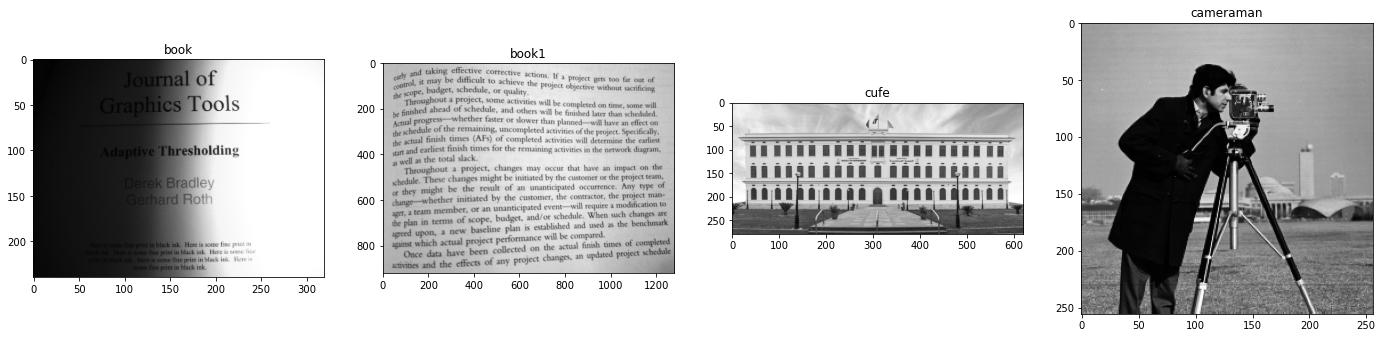

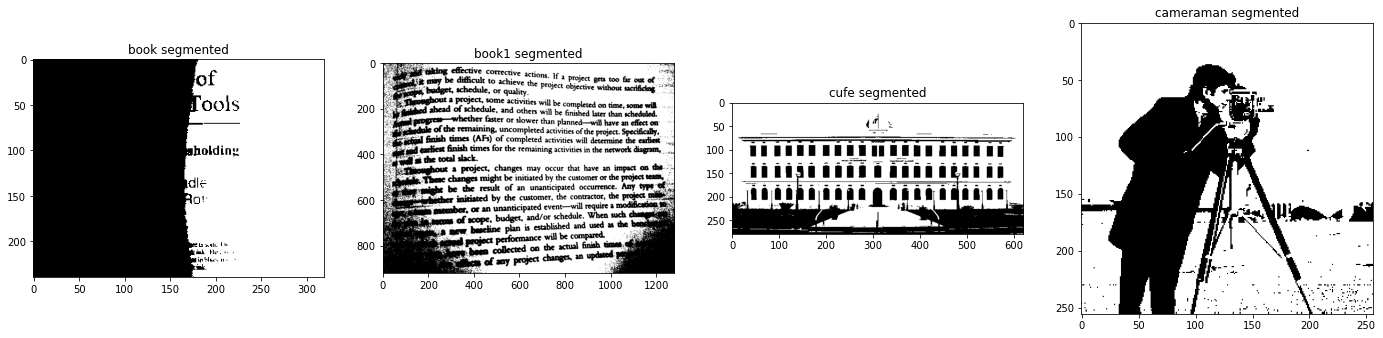

In [26]:
# read images 
book_image = io.imread('book.png')
book1_image = (255*rgb2gray(io.imread('book1.png')))
cameraman_image = io.imread('cameraman.png')
cufe_image = (255*rgb2gray(io.imread('cufe.png')))

# get thresholds for each image
book_threshold = getThreshold(book_image)
book1_threshold = getThreshold(book1_image)
cameraman_threshold = getThreshold(cameraman_image)
cufe_threshold = getThreshold(cufe_image) 

# apply segmentation using computed threshold
book_image_segmented = getSegmentedImage(book_image,book_threshold)
book1_image_segmented = getSegmentedImage(book1_image,book1_threshold)
cameraman_image_segmented = getSegmentedImage(cameraman_image, cameraman_threshold)
cufe_image_segmented = getSegmentedImage(cufe_image, cufe_threshold)

show_images([book_image,book1_image,cufe_image,cameraman_image],['book','book1','cufe','cameraman'])
show_images([book_image_segmented,book1_image_segmented,cufe_image_segmented,cameraman_image_segmented],['book segmented','book1 segmented','cufe segmented','cameraman segmented'])


In [27]:
def divideImage(image):

    width, height = image.shape
    half_width = (int)( width/2)
    half_height = (int)(height/2)

    # top left quarter of image
    image_one = image[0:half_width,0:half_height]

    # top right quarter of image
    image_two = image[half_width:width,0:half_height]

    # bottom left quarter of image
    image_three = image[0:half_width,half_height:height]

    # bottom right quarter of image
    image_four = image[half_width:width,half_height:height]

    return image_one, image_two, image_three, image_four



In [28]:
# local threshholding
def LocalThresholding(image):
    # divide image into four quarters
    image_first, image_second, image_third, image_fourth = divideImage(image)

    # get threshold of each quarter 
    threshold_one = getThreshold(image_first)
    threshold_two = getThreshold(image_second)
    threshold_three = getThreshold(image_third)
    threshold_four = getThreshold(image_fourth)

    # segment each quarter 
    segment_first = getSegmentedImage(image_first, threshold_one)
    segment_second = getSegmentedImage(image_second, threshold_two)
    segment_third = getSegmentedImage(image_third, threshold_three)
    segment_fourth = getSegmentedImage(image_fourth, threshold_four)

    # merge four quarters together again
    local_segmented_image = np.bmat([[segment_first,segment_third],[segment_second,segment_fourth]])

    return local_segmented_image

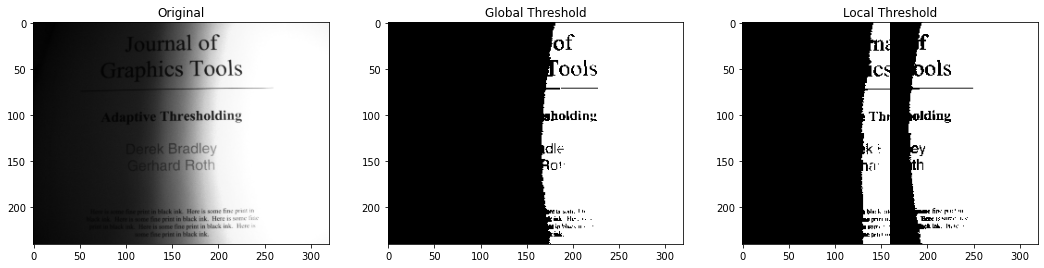

In [30]:
local_segmented_book = LocalThresholding(book_image)
show_images([book_image, book_image_segmented, local_segmented_book], ['Original', 'Global Threshold', 'Local Threshold'])